In [16]:
import os
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [17]:
seed = 42 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [19]:
class SingleSampleDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        self.images_in_memory = []

        # Collect image paths and corresponding labels
        for series in os.listdir(root_dir):
            series_path = os.path.join(root_dir, series)
            if os.path.isdir(series_path):
                for img_name in os.listdir(series_path):
                    if ".json" in img_name:
                        continue
                    img_path = os.path.join(series_path, img_name)
                    self.image_paths.append(img_path)
                    
                    label = img_name  
                    if label not in self.label_to_idx:
                        idx = len(self.label_to_idx)
                        self.label_to_idx[label] = idx
                        self.idx_to_label[idx] = label
                    
                    self.labels.append(self.label_to_idx[label])

                    # Load the image into memory
                    image = Image.open(img_path)
                    if image.mode != "RGB":
                        image = image.convert("RGB")
                    self.images_in_memory.append(image)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.images_in_memory[idx]
        label_idx = self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(label_idx), num_classes=len(self.label_to_idx))

        if self.transform:
            image = self.transform(image)

        return image, one_hot_label.float()
    
    def set_preprocessing(self, preprocessing):
        self.transform = preprocessing


class CardModel(nn.Module):
    def __init__(self, num_labels):
        super(CardModel, self).__init__()
        #####
        ##### BACKBONE DEFINITION
        #####
        self.weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2
        self.transform = self.weights.transforms()
        self.base_model = models.mobilenet_v3_large(self.weights)
        num_ftrs = self.base_model.classifier[3].in_features
        self.base_model.classifier[3] = nn.Identity()
        embedding_size = 256

        self.embedding_layer = nn.Linear(num_ftrs, embedding_size)
        self.classification_layer = nn.Linear(embedding_size, num_labels)

    def forward(self, x):
        x = self.base_model(x)
        x = self.embedding_layer(x) 
        logits = self.classification_layer(x)
        return x, logits

    def preprocess(self, image):
        return self.transform(image)
    
    def transform_info(self):
        mean = self.weights.transforms.func(crop_size=1).mean
        std = self.weights.transforms.func(crop_size=1).std
        crop_size = 224
        return mean, std, crop_size


In [20]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(1, 1),),
    transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.96, 1.06)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleSampleDataset(root_dir='cards')
dataset.set_preprocessing(transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=False)

In [21]:
with open('names.txt', 'w') as file:
    for key in list(dataset.label_to_idx.keys())[:-1]:
        file.write(key + '\n')
    file.write(key)

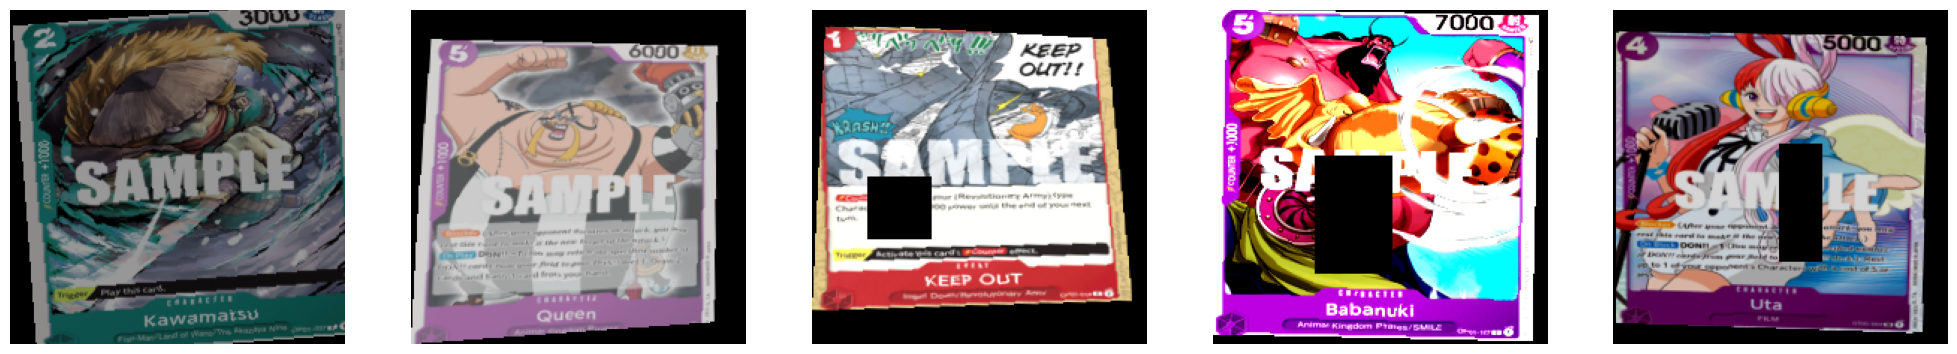

In [22]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# reverse normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

images = images * std[:, None, None] + mean[:, None, None]
images = images.numpy()
images = images.transpose((0, 2, 3, 1))
images = images[:5]
fig, axes = plt.subplots(1, len(images), figsize=(25, 25))
if len(images) == 1:
    axes = [axes]

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

In [23]:
model = CardModel(len(dataset.label_to_idx.keys())).to(device)
# Freeze all layers
for param in model.base_model.parameters():
    param.requires_grad = False

/Users/jan/Projects/tcg-scanner/.env/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [24]:
criterion = nn.CrossEntropyLoss()

def train_loop(num_epochs, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, one_hot_labels in train_loader:
            inputs = inputs.to(device)
            one_hot_labels = one_hot_labels.to(device)

            optimizer.zero_grad()
            
            embeddings, logits = model(inputs)
            
            labels = torch.argmax(one_hot_labels, dim=1)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach()
        
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loop(30, optimizer)

Epoch 1/1, Loss: 7.2454, Accuracy: 0.00%


In [ ]:
# Optionally, unfreeze more layers and fine-tune with a lower learning rate
for param in model.base_model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
train_loop(15, optimizer)

Epoch 1/25, Loss: 0.2568, Accuracy: 93.35%
Epoch 2/25, Loss: 0.2188, Accuracy: 94.21%
Epoch 3/25, Loss: 0.1262, Accuracy: 96.43%
Epoch 4/25, Loss: 0.1289, Accuracy: 96.35%
Epoch 5/25, Loss: 0.1097, Accuracy: 97.07%
Epoch 6/25, Loss: 0.1070, Accuracy: 97.14%
Epoch 7/25, Loss: 0.0952, Accuracy: 97.43%
Epoch 8/25, Loss: 0.0711, Accuracy: 98.00%
Epoch 9/25, Loss: 0.0562, Accuracy: 98.64%
Epoch 10/25, Loss: 0.0701, Accuracy: 98.00%
Epoch 11/25, Loss: 0.0712, Accuracy: 98.00%
Epoch 12/25, Loss: 0.0512, Accuracy: 98.64%
Epoch 13/25, Loss: 0.0510, Accuracy: 98.36%
Epoch 14/25, Loss: 0.0787, Accuracy: 97.78%
Epoch 15/25, Loss: 0.0428, Accuracy: 98.64%
Epoch 16/25, Loss: 0.0558, Accuracy: 98.71%
Epoch 17/25, Loss: 0.0440, Accuracy: 98.64%
Epoch 18/25, Loss: 0.0414, Accuracy: 99.00%
Epoch 19/25, Loss: 0.0288, Accuracy: 99.07%
Epoch 20/25, Loss: 0.0342, Accuracy: 99.07%
Epoch 21/25, Loss: 0.0357, Accuracy: 99.07%
Epoch 22/25, Loss: 0.0493, Accuracy: 98.78%
Epoch 23/25, Loss: 0.0285, Accuracy: 99.2

In [218]:
torch.save(model.state_dict(), f'{time.time()}_model_state_dict_mobile.pth')
torch.save(model, f'{time.time()}_model_save_mobile.pth')

In [26]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, one_hot_labels in train_loader:
        labels = torch.argmax(one_hot_labels.to(device), dim=1)
        embeddings, logits = model(inputs.to(device))
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f'Accuracy: {100 * correct / total}%')

Accuracy: 0.0%
Accuracy: 0.0%
Accuracy: 0.0%
Accuracy: 0.0%
Accuracy: 0.0%
Accuracy: 0.0%
Accuracy: 0.44642857142857145%


KeyboardInterrupt: 

In [27]:
def extract_embedding(model: CardModel, img_path):
    model.eval()
    image = Image.open(img_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = model.preprocess(image)
    with torch.no_grad():
        embedding, logits = model(image.unsqueeze(0).to(device))
    return F.normalize(embedding, p=2, dim=1).cpu().numpy().flatten(), logits

In [28]:
import re
def extract_prefix(card_id):
    match = re.match(r'^[^-]+', card_id)
    return match.group(0) if match else ''

OP06-088.jpg


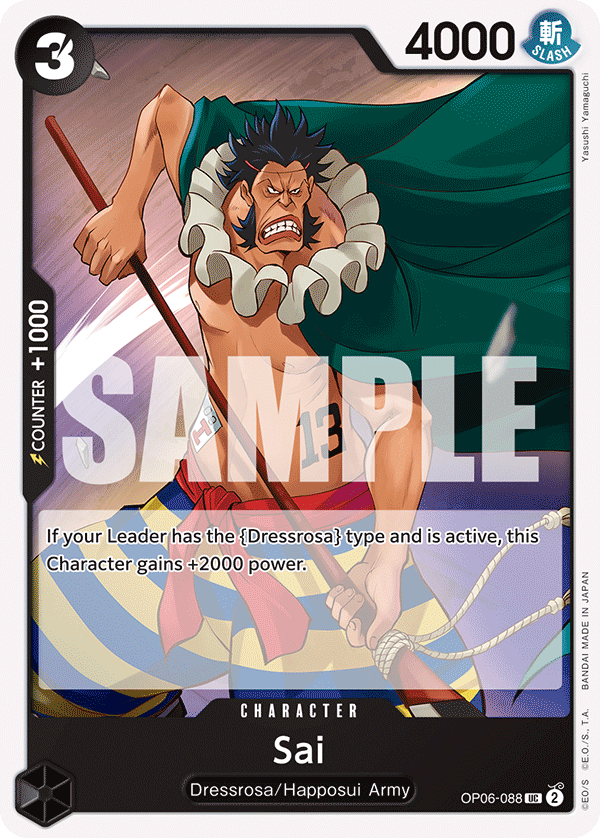

In [29]:
embedding, logits = extract_embedding(model, "monkey.png")

probabilities = F.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)

predicted_class = predicted_class.item()
predicted_class_name = dataset.idx_to_label[predicted_class]
print(predicted_class_name)
image = Image.open("cards/" +  extract_prefix(predicted_class_name) + "/" + predicted_class_name)
image

In [223]:
card_embeddings = []
root_dir = "cards"
index = 0
index_to_card_id = {}

for series in os.listdir(root_dir):
    series_path = os.path.join(root_dir, series)
    if os.path.isdir(series_path):
        for img_name in os.listdir(series_path):
            if ".json" in img_name:
                continue
            img_path = os.path.join(series_path, img_name)
            label = img_name  
            embedding, _ = extract_embedding(model, img_path)
            card_embeddings.append(embedding)
            index_to_card_id[index] = label
            index += 1

In [226]:
from sklearn.metrics.pairwise import euclidean_distances
from pathlib import Path

def find_image_path(card_id, root_dir="cards"):
    root_path = Path(root_dir)
    for image_path in root_path.rglob(f"{card_id}"):
        return image_path
    return None

card_embeddings_np = np.array(card_embeddings, dtype='float32')

# Define a query vector
query_embedding, _ = extract_embedding(model, "monkey.png") 
query_embedding = np.array([query_embedding]) 

distances = euclidean_distances(card_embeddings_np, query_embedding)

# Find the indices of the 5 closest vectors
top_k = 5
closest_indices = np.argsort(distances.flatten())[:top_k]

# Retrieve the closest card IDs
closest_card_ids = [index_to_card_id[idx] for idx in closest_indices]
closest_distances = [distances[idx][0] for idx in closest_indices]

Match 1:
Card ID: OP05-119.jpg
Distance: 0.791215181350708


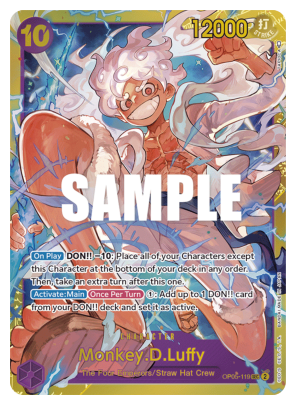

Match 2:
Card ID: OP06-118.jpg
Distance: 0.9394112229347229


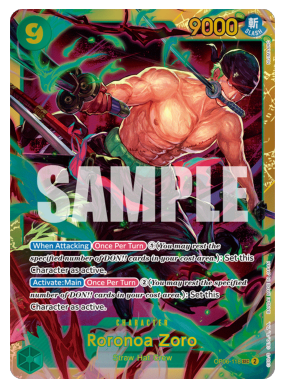

Match 3:
Card ID: OP02-073_p1.jpg
Distance: 0.9500589966773987


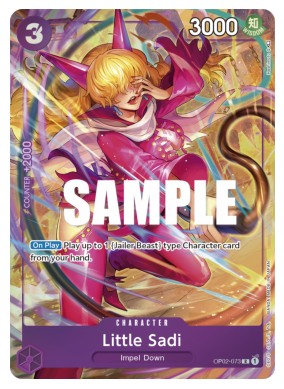

Match 4:
Card ID: OP05-043.jpg
Distance: 0.9726888537406921


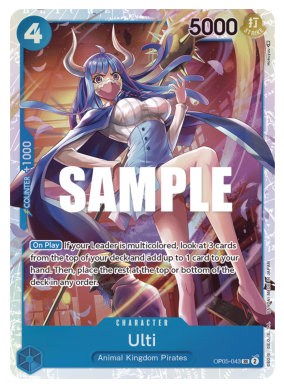

Match 5:
Card ID: OP01-051_p1.jpg
Distance: 0.9749125242233276


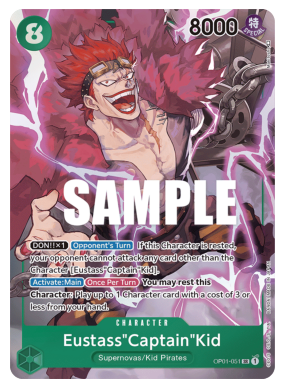

In [227]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
if top_k == 1:
    axes = [axes] 

for i, card_id in enumerate(closest_card_ids):
    image_path = find_image_path(card_id)
    if image_path:
        image = Image.open(image_path)
        print(f"Match {i + 1}:")
        print(f"Card ID: {card_id}")
        print(f"Distance: {closest_distances[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [ ]:
obj_weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
obj_weights.transforms()

In [207]:
device = torch.device("mps")
image = Image.open("monkey.png")
if image.mode != "RGB":
    image = image.convert("RGB")

weights = torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
mobile = torchvision.models.mobilenet_v3_small(weights=weights)

preprocess = weights.transforms()
mobile.eval()
mobile.to(device)

batch = preprocess(image).unsqueeze(0)
# Step 4: Use the model and print the predicted category
prediction = mobile(batch)

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [208]:
weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
mobile = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=weights)
mobile.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [209]:
%%time 
prediction = mobile(batch)
prediction = mobile(batch)
prediction = mobile(batch)

CPU times: user 681 ms, sys: 118 ms, total: 799 ms
Wall time: 238 ms
